# Import Packages

In [39]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, spraychart, statcast_sprint_speed, statcast_running_splits
from pybaseball.plotting import plot_bb_profile


'''
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay, f1_score, recall_score, precision_score
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


import os.path
from os import path

import math

# Case Study: Corbin Carroll

Motivating some thought about how speed can affect ISO stats is the outlier speed of Arizona's Corbin Carroll. Just watching him easily take 3rd on line drives down the right field line made me think about how much his speed allows him to turn singles into double and doubles into triples more than the average baserunner. It's clips like [these](https://baseballsavant.mlb.com/sporty-videos?playId=d2128c8a-5042-4933-b11d-8c8234c238f4) that I'm talking about. Or [this](https://baseballsavant.mlb.com/sporty-videos?playId=ef1521b1-c403-4dfb-98e9-1b77b98c4eec&videoType=AWAY).

Side note: Inside-the-park home runs depend on much more than just a baserunner's speed alone, so I find the value in accounting for them to be too small to warrant considering them.

I'll start by taking Carroll's small sample of 2022 batted balls that converted to hits and examining their distribution over the entire field.

## Data Gathering

In [3]:
# Statcast lookup
carroll_id = playerid_lookup('carroll','corbin')['key_mlbam'][0]

carroll = statcast_batter('2022-04-01', '2022-10-03', player_id = carroll_id)

#for i in carroll.columns:
#  print(i)

Gathering player lookup table. This may take a moment.
Gathering Player Data


With the available Statcast data imported, the question becomes: what data should we be looking for? A [post from MLB Technology Blog](https://technology.mlblogs.com/an-introduction-to-expected-weighted-on-base-average-xwoba-29d6070ba52b) describing their xwOBA model provides some answers. For instance, batted balls will be biased to some degree by temperature, which is a function of both month and home park (open air, open/closed roof). For now, we can include both date and home_team as a proxy for home park. We'll also include all of the batted ball stats, measured and estimated from internal models.

Short digression: A model based off the data I am looking for will differ at least slightly from the xwOBA model. For example, the xwOBA KNN model does not care for actual batted ball outcomes included scoring, spray angle, distance, etc. For now, I will care about these variables as I am trying to model likelihoods of hits based off both player skill and batted outcomes such as distance. However, I will keep open the possibility of ignoring batted ball outcomes other than the event in potential models.

In [4]:
hit_vars = ['game_date','home_team','batter','description', 'des', 'events', 'hit_location', 'hit_distance_sc','bb_type', 'hc_x', 'hc_y', "launch_speed","launch_angle",
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'iso_value',
       'launch_speed_angle','of_fielding_alignment', 
       'delta_home_win_exp', 'delta_run_exp']

In [5]:
# Return only balls in play, and then hits
carroll_BIP = carroll[hit_vars]
carroll_BIP = carroll_BIP[carroll_BIP['description'] == 'hit_into_play']
print('Dimensions (Balls in Play):', carroll_BIP.shape, '\n')

hits = ['triple','single','double','home_run']
carroll_hits = carroll_BIP[carroll_BIP['events'].isin(hits)]
print("Dimensions (Hits): " + str(carroll_hits.shape))

carroll_hits.head()

Dimensions (Balls in Play): (71, 22) 

Dimensions (Hits): (26, 22)


,game_date,home_team,batter,description,des,events,hit_location,hit_distance_sc,bb_type,hc_x,...,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,iso_value,launch_speed_angle,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,2022-10-03,MIL,682998,hit_into_play,Corbin Carroll triples (2) on a sharp line dri...,triple,8.0,311.0,line_drive,146.66,...,13.0,0.806,0.841,1.60,1.0,2.0,5.0,Standard,-0.123,0.912
36,2022-10-02,SF,682998,hit_into_play,Corbin Carroll singles on a ground ball to sho...,single,6.0,3.0,ground_ball,110.09,...,-33.0,0.063,0.063,0.90,1.0,0.0,2.0,Standard,-0.068,0.637
44,2022-10-01,SF,682998,hit_into_play,Corbin Carroll doubles (9) on a fly ball to le...,double,7.0,233.0,fly_ball,61.35,...,49.0,0.069,0.062,1.25,1.0,1.0,3.0,Standard,-0.046,0.633
45,2022-10-01,SF,682998,hit_into_play,Corbin Carroll doubles (8) on a line drive to ...,double,9.0,233.0,line_drive,200.37,...,16.0,0.571,0.590,1.25,1.0,1.0,4.0,Standard,-0.028,0.261
69,2022-09-30,SF,682998,hit_into_play,Corbin Carroll doubles (7) on a ground ball to...,double,8.0,20.0,ground_ball,139.46,...,-6.0,0.260,0.234,1.25,1.0,1.0,2.0,Standard,-0.005,0.750


## Game Date


Per pybaseball, the game_date column comes in yyyy-mm-dd string format. Two ways to use this column exist: one, simply take the month and one-hot encode it during preprocessing. Or two, take the date and scale it according to how many weeks after Opening Day (April 1st, 2022) the game took place.

In [6]:
from datetime import datetime

carroll_hits['game_date'] = carroll_hits['game_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date().strftime("%B %d, %Y").split(' ')[0])

carroll_hits = carroll_hits.rename(columns={'game_date': 'month'})
carroll_hits.head(10)

<ipython-input-6-8251707b5504>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carroll_hits['game_date'] = carroll_hits['game_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date().strftime("%B %d, %Y").split(' ')[0])


,month,home_team,batter,description,des,events,hit_location,hit_distance_sc,bb_type,hc_x,...,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,iso_value,launch_speed_angle,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,October,MIL,682998,hit_into_play,Corbin Carroll triples (2) on a sharp line dri...,triple,8.0,311.0,line_drive,146.66,...,13.0,0.806,0.841,1.60,1.0,2.0,5.0,Standard,-0.123,0.912
36,October,SF,682998,hit_into_play,Corbin Carroll singles on a ground ball to sho...,single,6.0,3.0,ground_ball,110.09,...,-33.0,0.063,0.063,0.90,1.0,0.0,2.0,Standard,-0.068,0.637
44,October,SF,682998,hit_into_play,Corbin Carroll doubles (9) on a fly ball to le...,double,7.0,233.0,fly_ball,61.35,...,49.0,0.069,0.062,1.25,1.0,1.0,3.0,Standard,-0.046,0.633
45,October,SF,682998,hit_into_play,Corbin Carroll doubles (8) on a line drive to ...,double,9.0,233.0,line_drive,200.37,...,16.0,0.571,0.590,1.25,1.0,1.0,4.0,Standard,-0.028,0.261
69,September,SF,682998,hit_into_play,Corbin Carroll doubles (7) on a ground ball to...,double,8.0,20.0,ground_ball,139.46,...,-6.0,0.260,0.234,1.25,1.0,1.0,2.0,Standard,-0.005,0.750
95,September,HOU,682998,hit_into_play,Corbin Carroll singles on a soft ground ball t...,single,5.0,1.0,ground_ball,120.37,...,-67.0,0.214,0.193,0.90,1.0,0.0,1.0,Standard,-0.015,0.102
135,September,AZ,682998,hit_into_play,Corbin Carroll singles on a sharp line drive t...,single,7.0,224.0,line_drive,71.46,...,12.0,0.889,0.893,0.90,1.0,0.0,4.0,Standard,0.005,0.270
164,September,LAD,682998,hit_into_play,Corbin Carroll doubles (6) on a sharp line dri...,double,8.0,319.0,line_drive,139.94,...,15.0,0.637,0.702,1.25,1.0,1.0,5.0,Standard,-0.124,1.848
182,September,LAD,682998,hit_into_play,Corbin Carroll singles on a fly ball to right ...,single,9.0,219.0,fly_ball,174.11,...,27.0,0.951,0.917,0.90,1.0,0.0,4.0,Standard,-0.034,0.404
189,September,LAD,682998,hit_into_play,Corbin Carroll triples (1) on a line drive to ...,triple,9.0,219.0,line_drive,215.76,...,16.0,0.837,0.844,1.60,1.0,2.0,4.0,Standard,-0.047,1.216


In [7]:
carroll_hits = carroll_BIP[carroll_BIP['events'].isin(hits)]

season_start = datetime.strptime('2022-04-01', '%Y-%m-%d').date()
carroll_hits['game_date'] = carroll_hits['game_date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').date() - season_start).days // 7)

#print(carroll_hits['game_date'][0], "Weeks from April 1st:", abs(carroll_hits['game_date'][0] -season_start).days // 7) 
carroll_hits.head(10)

<ipython-input-7-938b78a3d68c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carroll_hits['game_date'] = carroll_hits['game_date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').date() - season_start).days // 7)


,game_date,home_team,batter,description,des,events,hit_location,hit_distance_sc,bb_type,hc_x,...,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,iso_value,launch_speed_angle,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,26,MIL,682998,hit_into_play,Corbin Carroll triples (2) on a sharp line dri...,triple,8.0,311.0,line_drive,146.66,...,13.0,0.806,0.841,1.60,1.0,2.0,5.0,Standard,-0.123,0.912
36,26,SF,682998,hit_into_play,Corbin Carroll singles on a ground ball to sho...,single,6.0,3.0,ground_ball,110.09,...,-33.0,0.063,0.063,0.90,1.0,0.0,2.0,Standard,-0.068,0.637
44,26,SF,682998,hit_into_play,Corbin Carroll doubles (9) on a fly ball to le...,double,7.0,233.0,fly_ball,61.35,...,49.0,0.069,0.062,1.25,1.0,1.0,3.0,Standard,-0.046,0.633
45,26,SF,682998,hit_into_play,Corbin Carroll doubles (8) on a line drive to ...,double,9.0,233.0,line_drive,200.37,...,16.0,0.571,0.590,1.25,1.0,1.0,4.0,Standard,-0.028,0.261
69,26,SF,682998,hit_into_play,Corbin Carroll doubles (7) on a ground ball to...,double,8.0,20.0,ground_ball,139.46,...,-6.0,0.260,0.234,1.25,1.0,1.0,2.0,Standard,-0.005,0.750
95,25,HOU,682998,hit_into_play,Corbin Carroll singles on a soft ground ball t...,single,5.0,1.0,ground_ball,120.37,...,-67.0,0.214,0.193,0.90,1.0,0.0,1.0,Standard,-0.015,0.102
135,25,AZ,682998,hit_into_play,Corbin Carroll singles on a sharp line drive t...,single,7.0,224.0,line_drive,71.46,...,12.0,0.889,0.893,0.90,1.0,0.0,4.0,Standard,0.005,0.270
164,24,LAD,682998,hit_into_play,Corbin Carroll doubles (6) on a sharp line dri...,double,8.0,319.0,line_drive,139.94,...,15.0,0.637,0.702,1.25,1.0,1.0,5.0,Standard,-0.124,1.848
182,24,LAD,682998,hit_into_play,Corbin Carroll singles on a fly ball to right ...,single,9.0,219.0,fly_ball,174.11,...,27.0,0.951,0.917,0.90,1.0,0.0,4.0,Standard,-0.034,0.404
189,24,LAD,682998,hit_into_play,Corbin Carroll triples (1) on a line drive to ...,triple,9.0,219.0,line_drive,215.76,...,16.0,0.837,0.844,1.60,1.0,2.0,4.0,Standard,-0.047,1.216


## Hit Locations

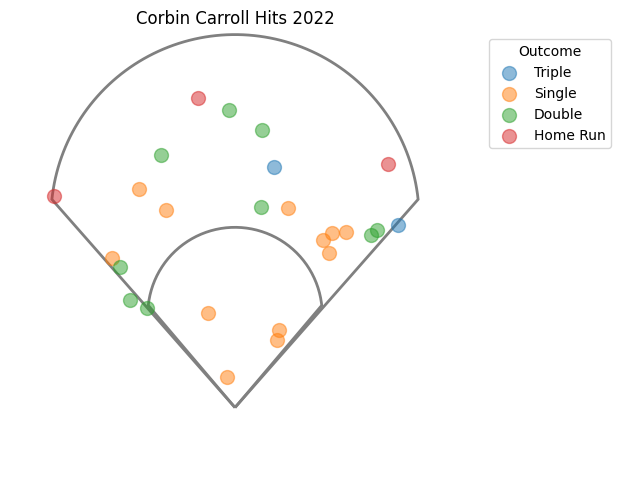

<Axes: title={'center': 'Corbin Carroll Hits 2022'}>

In [8]:
# Spraychart function
spraychart(carroll_hits, 'generic', title='Corbin Carroll Hits 2022')

### Normalizing Hit Coordinates via Linear Transformation

Going through the hit coordinate data and spraychart for Carroll, I noticed that the placement of each hit, their hit coordinates, and distance carried discrepancies. I'm not satisfied with taking the spraychart at its word, so I'll devote some time to recreating the spraychart output from "scratch" with the hit coordinates themselves. 

Specifically, I want to see how the hit coordinates in their requested form are translated to the points seen in a spraychart. This involves using some code to create a visualization of all the coordinate's translations. A reference outlining how can be found at [r/Sabermetrics.](!https://www.reddit.com/r/Sabermetrics/comments/dbyw0r/hit_location_data/)

#### Helper Functions

In [9]:
# Code taken from: https://dododas.github.io/linear-algebra-with-python/posts/16-12-29-2d-transformations.html

# To animate the transform, we generate a series of intermediates
# Function to compute all intermediate transforms
def stepwise_transform(a, points, nsteps=30):
    '''
    Generate a series of intermediate transform for linear translation
      (hc_x - 130, 210 - hc_y)
    '''
    # create empty array of the right size
    transgrid = np.zeros((nsteps+1,) + np.shape(points))
    # compute intermediate transforms
    for j in range(nsteps+1):
        intermediate = j/nsteps*(np.asarray([130,210])) 
        #print(intermediate)
        transgrid[j] = np.asarray([[i - intermediate[0] for i in points[0]], [intermediate[1] - i for i in points[1]]]) # apply intermediate matrix transformation
    return transgrid

In [10]:
# Code taken from: https://dododas.github.io/linear-algebra-with-python/posts/16-12-29-2d-transformations.html

# Create a series of figures showing the intermediate transforms
def make_plots(transarray, color, outdir="png-frames", figuresize=(4,4), figuredpi=150):
    '''
    Generate a series of png images showing a linear transformation stepwise
    '''
    nsteps = transarray.shape[0]
    ndigits = len(str(nsteps)) # to determine filename padding
    maxval = np.abs(transarray.max()) # to set axis limits
    
    # create directory if necessary
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    # create figure
    plt.ioff()

    fig = plt.figure(figsize=figuresize, facecolor="w")
    for j in range(nsteps): # plot individual frames
        plt.cla()
        plt.scatter(transarray[j,0], transarray[j,1], s=36, c=color, edgecolor="none")
        plt.xlim(1.1*np.array([-maxval, maxval]))
        plt.ylim(1.1*np.array([-maxval, maxval]))
        plt.grid(True)
        plt.draw()
        # save as png
        outfile = os.path.join(outdir, "frame-" + str(j+1).zfill(ndigits) + ".png")
        fig.savefig(outfile, dpi=figuredpi)
    plt.ion()

In [11]:
# Code taken from: https://www.blog.pythonlibrary.org/2021/06/23/creating-an-animated-gif-with-python/

import glob
from PIL import Image

def make_gif(frame_folder, gif_name):
    '''
    Create a GIF sequencing all images in a directory together into a short clip
    '''
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    print(frames)
    frame_one = frames[0]
  
    frame_one.save(gif_name, format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)

#### Make GIF for Changing Orientation

Statcast hc_x and hc_y come in a strange form relative to how they are represented in a spray chart. In standard Cartesian coordinates, it appears as if (0,0) is down the first base line, and all the points as they are recorded face in the negative-y direction. So to visualize exactly how you convert the raw hc_x and hc_y to the "correct" (Cartesian) values, all points are flipped and translated to a new set of points, where home plate is the origin and all batted ball coordinates are found in the Quadrants 1 and 2, the positive-y direction. 

In [12]:
carroll_hit_data = carroll_hits[['game_date','batter','events','des','hc_x','hc_y','bb_type','launch_speed_angle',"launch_speed","launch_angle",'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle','delta_run_exp','hit_distance_sc']]

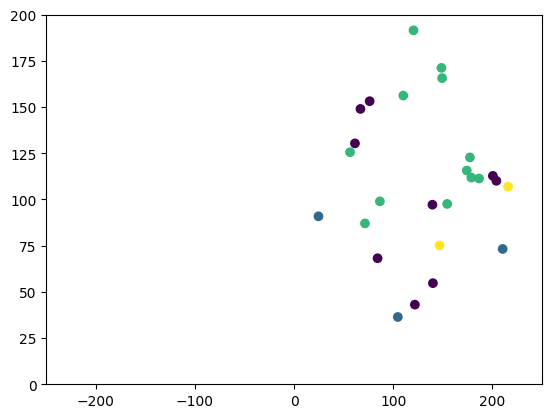

In [13]:
if path.exists('translation') == False:
  os.mkdir('translation')

# First Image: all hit coordinates in pure form as requested from Statcast
scatter = plt.scatter(carroll_hit_data['hc_x'],carroll_hit_data['hc_y'], c = carroll_hit_data.events.astype('category').cat.codes)
ax = scatter.axes
plt.xlim(-250,250)
plt.ylim(0,200)
plt.savefig('translation/1.png')


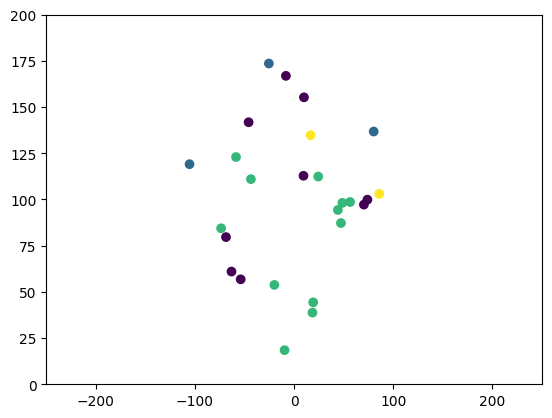

In [14]:
# Second Image: all hit coordinates reflected and translated from original points to new set of points

scatter2 = plt.scatter(carroll_hit_data['hc_x'] - 130 ,210-carroll_hit_data['hc_y'], c = carroll_hit_data.events.astype('category').cat.codes)
ax2 = scatter2.axes
plt.xlim(-250,250)
plt.ylim(0,200)
plt.savefig('translation/2.png')

In [15]:
make_gif("translation", "translation.gif")

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FA0309ABDC0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FA031A1B3D0>]


#### Make GIF for point movement to (0,0)

After creating the first GIF, we'll visualize the steps between the two images and create a GIF of the translation of hit coordiantes to their new positions.

In [16]:
# Sets starting and end points to perform translation, captured in several images
xy_points = np.asarray([carroll_hit_data.hc_x, carroll_hit_data.hc_y])
xy_trans = np.asarray([[i - 130 for i in xy_points[0]], [210 - i for i in xy_points[1]]])

# Apply to x-y grid
steps = 5
xy_transform = stepwise_transform(a = (130, 210), points = xy_points, nsteps=steps)

In [17]:
# Generate figures
make_plots(xy_transform, color = carroll_hit_data.events.astype('category').cat.codes, outdir="transform_steps")

# Create GIF
make_gif("transform_steps", 'transformation.gif')

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=600x600 at 0x7FA033A67850>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=600x600 at 0x7FA033A66170>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=600x600 at 0x7FA033AAD2D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=600x600 at 0x7FA033AAF700>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=600x600 at 0x7FA033AAF280>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=600x600 at 0x7FA033AAF3A0>]


## Recreate Plots

### Cartesian

After performing the necessary translations, the Cartesian plane spraychart now makes a little more intutive sense. The spraychart from the pybaseball package  can now be "reproduced" below in standard matplotlib code.

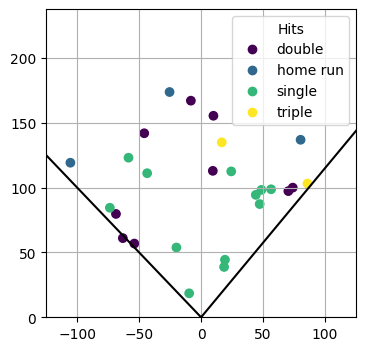

In [18]:
scatter = plt.scatter(carroll_hit_data['hc_x'] - 130 ,210-carroll_hit_data['hc_y'], c = carroll_hit_data.events.astype('category').cat.codes)
ax = scatter.axes
plt.axline(xy1=(0.0,0.0),slope = 1.15, color = 'black')
plt.axline(xy1=(0.0,0.0),slope = -1, color = 'black')
plt.xlim(-125,125)
plt.ylim(bottom=0)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=['double','home run','single','triple'],
           title="Hits")
plt.show()

### Polar Coordinates

Previously, hit_distance_sc was used to plot the "r" value in polar coordinates. By using hit_distance_sc however, there are discrepancies in individual coordinates between a polar plot and the Cartesian spraychart. However, r can be solved for directly by taking the hypotenuse of hc_x and hc_y, giving r values that recreates the same plot seen in the spraychart() function and recreated Cartesian plot (with translations done on raw hc_x and hc_y), only in polar coordinates.

In [19]:
# Takes negative arctangent of translated x and y coordiantes (x/y), shifted by pi/2  to match appearance of spraychart
carroll_hit_data['angle'] = (-1*np.arctan((carroll_hit_data.hc_x - 130)/(210 - carroll_hit_data.hc_y))) + (np.pi / 2)

# Given x and y, we calculate r value for polar coordiantes by simply taking hypotenuse of x and y
carroll_hit_data['r'] = np.hypot((210 - carroll_hit_data.hc_y),(carroll_hit_data.hc_x - 130))

<ipython-input-19-12ecde0a068e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carroll_hit_data['angle'] = (-1*np.arctan((carroll_hit_data.hc_x - 130)/(210 - carroll_hit_data.hc_y))) + (np.pi / 2)
<ipython-input-19-12ecde0a068e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carroll_hit_data['r'] = np.hypot((210 - carroll_hit_data.hc_y),(carroll_hit_data.hc_x - 130))


In [20]:
carroll_hit_data.head()

,game_date,batter,events,des,hc_x,hc_y,bb_type,launch_speed_angle,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,delta_run_exp,hit_distance_sc,angle,r
0,26,682998,triple,Corbin Carroll triples (2) on a sharp line dri...,146.66,75.19,line_drive,5.0,107.5,13.0,0.806,0.841,0.912,311.0,1.447838,135.835532
36,26,682998,single,Corbin Carroll singles on a ground ball to sho...,110.09,156.23,ground_ball,2.0,83.1,-33.0,0.063,0.063,0.637,3.0,1.925423,57.337780
44,26,682998,double,Corbin Carroll doubles (9) on a fly ball to le...,61.35,130.36,fly_ball,3.0,77.1,49.0,0.069,0.062,0.633,233.0,2.282218,105.144434
45,26,682998,double,Corbin Carroll doubles (8) on a line drive to ...,200.37,112.77,line_drive,4.0,99.7,16.0,0.571,0.590,0.261,233.0,0.944309,120.023372
69,26,682998,double,Corbin Carroll doubles (7) on a ground ball to...,139.46,97.17,ground_ball,2.0,99.2,-6.0,0.260,0.234,0.750,20.0,1.487149,113.225883


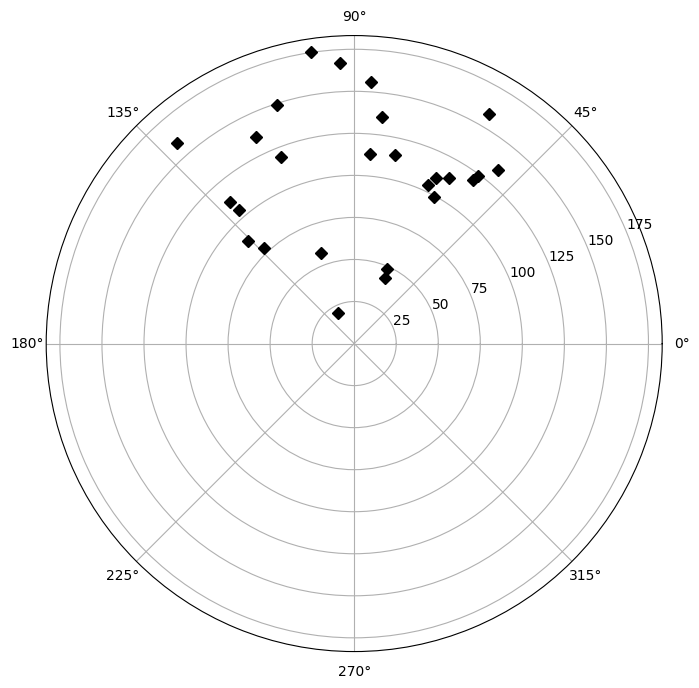

In [21]:
fig 	= plt.figure(figsize = (15,8))
ax	= fig.add_subplot(111, polar=True)

# Create first plot using polar coordaintes
for x, y in zip(carroll_hit_data.angle, carroll_hit_data.r):
    ax.plot(x, y, 'kD')

## Calculating own distance metrics


The discrepancy between hit_distance_sc and final coordinates for hits has been solved for, giving us a good representation of a spraychart in polar coordinates. Each batted ball represented in (r,theta) instead of (hc_x,h hc_y). However, there is still one more problem: the discrepancy between hit_distance_sc and the r-value itself. Note that hit_distance_sc as a variable gives a value for the _projected_ hit distance of a ball from the point it makes contact with the bat to when it *first hits the ground*. By comparing this with r-values, there are instances of hit_distance_sc being either far below or above r-values. A good example is this [infield single](https://baseballsavant.mlb.com/sporty-videos?playId=fc994889-5f80-4ac0-90c1-a77330cb7354) from Corbin Carroll: projected distance of 1, but total distance traveled greater than 1.

How could something like this be reconciled? I propose scaling all r-values up by a number that gives a close match to the total distance traveled as captured by the hc_x and hc_y coordiantes, the same idea as multiplying wOBA numbers by a scaling factor relative to OBP. Intutively, this means finding that scalar from calculating the proportion of distance in feet to r. Therefore, a scalar would have to be found through instances where projected distance and hc_x and hc_y likely have little discrepancy. The clear and obvious case: when a ball in play does not have to be tracked to see when it is picked up by a fielder to find hc_x and hc_y. Therefore, our scalar for transforming r-values to distance will likely be found in home runs. Assumung that the hc_x and hc_y of home runs is where the ball lands out of play, there is at least a (crude but decent enough) proxy for total distance. 

To find this value, we take all home runs, divide the Statcast projected distance by the r-value, average all quotients together, and multiply all other r-values by this scalar to approximate total distance traveled by balls in play that, including the distance traveled after a ball has first hit the ground.



In [22]:
# taking all home runs, average over the proportion of projected distance to r value
r_value_multiplier = np.mean(carroll_hit_data[carroll_hit_data.events == 'home_run']['hit_distance_sc'] / carroll_hit_data[carroll_hit_data.events == 'home_run']['r'])
r_value_multiplier

2.3204865722888006

In [23]:
# Scale up all values by r-value scalar to get better measure of total distance traveled
carroll_hit_data['calc_distance'] = round(carroll_hit_data['r'] * r_value_multiplier,0)
carroll_hit_data.head()

<ipython-input-23-457661dd615b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carroll_hit_data['calc_distance'] = round(carroll_hit_data['r'] * r_value_multiplier,0)


,game_date,batter,events,des,hc_x,hc_y,bb_type,launch_speed_angle,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,delta_run_exp,hit_distance_sc,angle,r,calc_distance
0,26,682998,triple,Corbin Carroll triples (2) on a sharp line dri...,146.66,75.19,line_drive,5.0,107.5,13.0,0.806,0.841,0.912,311.0,1.447838,135.835532,315.0
36,26,682998,single,Corbin Carroll singles on a ground ball to sho...,110.09,156.23,ground_ball,2.0,83.1,-33.0,0.063,0.063,0.637,3.0,1.925423,57.337780,133.0
44,26,682998,double,Corbin Carroll doubles (9) on a fly ball to le...,61.35,130.36,fly_ball,3.0,77.1,49.0,0.069,0.062,0.633,233.0,2.282218,105.144434,244.0
45,26,682998,double,Corbin Carroll doubles (8) on a line drive to ...,200.37,112.77,line_drive,4.0,99.7,16.0,0.571,0.590,0.261,233.0,0.944309,120.023372,279.0
69,26,682998,double,Corbin Carroll doubles (7) on a ground ball to...,139.46,97.17,ground_ball,2.0,99.2,-6.0,0.260,0.234,0.750,20.0,1.487149,113.225883,263.0


(40.0, 140.0)

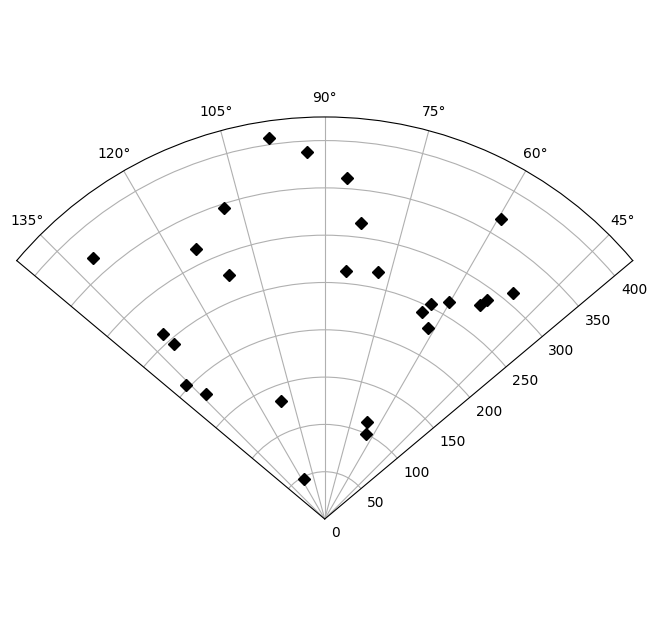

In [24]:
# Replot in polar coordiantes, with total distance
fig 	= plt.figure(figsize = (15,8))
ax	= fig.add_subplot(111, polar=True)

for x, y in zip(carroll_hit_data.angle, carroll_hit_data.calc_distance):
    ax.plot(x, y, 'kD')

ax.set_thetalim((40*np.pi)/180, (140*np.pi)/180)

## Speed

Moving onto speed, sprint speed can be acquired for players via Statcast leaderboards. To include as many players as possible, the number of baserunning opportunities will be set at the lowest number possible. I'll also visualize how sprint speed is distributed over the entire population of players (who have speed data).

In [25]:
# Read in Statcast sprint speed data
sprint_data22 = statcast_running_splits(2022, 1, raw_splits = True)
speed_data22 = statcast_sprint_speed(2022, 1)

print("Statcast Running Splits Dimensions:", sprint_data22.shape)
print("Statcast Sprint Speed Dimensions:", speed_data22.shape)

Statcast Running Splits Dimensions: (574, 27)
Statcast Sprint Speed Dimensions: (624, 11)


In [26]:
print(sprint_data22.columns)
sprint_data22.head()

Index(['last_name', 'first_name', 'player_id', 'name_abbrev', 'team_id',
       'position_name', 'age', 'bat_side', 'seconds_since_hit_000',
       'seconds_since_hit_005', 'seconds_since_hit_010',
       'seconds_since_hit_015', 'seconds_since_hit_020',
       'seconds_since_hit_025', 'seconds_since_hit_030',
       'seconds_since_hit_035', 'seconds_since_hit_040',
       'seconds_since_hit_045', 'seconds_since_hit_050',
       'seconds_since_hit_055', 'seconds_since_hit_060',
       'seconds_since_hit_065', 'seconds_since_hit_070',
       'seconds_since_hit_075', 'seconds_since_hit_080',
       'seconds_since_hit_085', 'seconds_since_hit_090'],
      dtype='object')


,last_name,first_name,player_id,name_abbrev,team_id,position_name,age,bat_side,seconds_since_hit_000,seconds_since_hit_005,...,seconds_since_hit_045,seconds_since_hit_050,seconds_since_hit_055,seconds_since_hit_060,seconds_since_hit_065,seconds_since_hit_070,seconds_since_hit_075,seconds_since_hit_080,seconds_since_hit_085,seconds_since_hit_090
0,Abrams,CJ,682928,WSH,120,SS,21,L,0.0,0.53,...,2.27,2.44,2.62,2.79,2.95,3.12,3.29,3.45,3.63,3.82
1,Abreu,José,547989,CWS,145,1B,35,R,0.0,0.57,...,2.52,2.71,2.90,3.09,3.27,3.46,3.64,3.83,4.02,4.22
2,Acuña Jr.,Ronald,660670,ATL,144,RF,24,R,0.0,0.54,...,2.30,2.48,2.65,2.82,2.99,3.16,3.32,3.49,3.65,3.82
3,Adames,Willy,642715,MIL,158,SS,26,R,0.0,0.56,...,2.40,2.59,2.77,2.94,3.12,3.29,3.47,3.64,3.81,3.99
4,Adams,Riley,656180,WSH,120,C,26,R,0.0,0.56,...,2.47,2.66,2.86,3.04,3.23,3.42,3.60,3.79,3.97,4.17


In [27]:
speed_data22.head()

,last_name,first_name,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,Carroll,Corbin,682998,109,AZ,LF,21,52,31.0,4.05,30.7
1,Thompson,Bubba,669352,140,TEX,LF,24,60,44.0,4.16,30.4
2,Witt Jr.,Bobby,677951,118,KC,SS,22,202,107.0,4.13,30.4
3,Siri,Jose,642350,139,TB,CF,26,95,46.0,4.20,30.4
4,Turner,Trea,607208,119,LAD,SS,29,276,131.0,4.14,30.3


In [28]:
speed_data22.tail()

,last_name,first_name,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
619,Cabrera,Miguel,408234,116,DET,DH,39,147,NaN,5.13,23.1
620,Pujols,Albert,405395,138,STL,DH,42,94,NaN,5.08,22.6
621,Maldonado,Martín,455117,117,HOU,C,35,95,NaN,5.07,22.4
622,Grandal,Yasmani,518735,145,CWS,C,33,94,NaN,5.26,22.0
623,Molina,Yadier,425877,138,STL,C,39,80,NaN,5.07,21.8


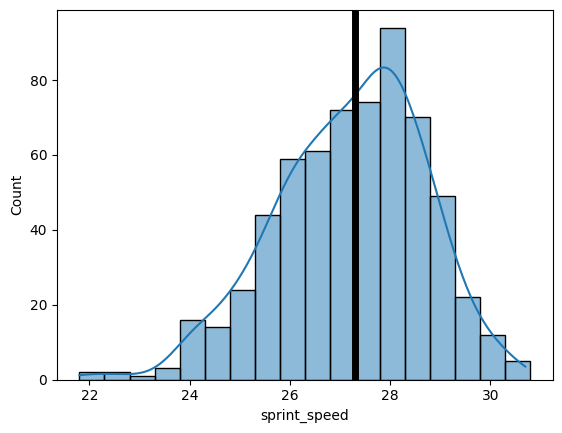

In [29]:
# Builds histogram of 2022 sprint speed (skewed left)
sns.histplot(speed_data22.sprint_speed, binwidth = 0.5, kde = True).axvline(np.median(speed_data22.sprint_speed), color = 'black', linewidth = 5)

### Sprint Speed Imputation

If sprint speed is going to be accounted for when trying to determine difference in batted ball outcomes with speed, then speed will have to be added as a column to our current dataset. There is just one problem: in public Statcast data, there is no variable for sprint speed of the batter that is unique to each batted ball event. To start, I can at least add the sprint speed leaderboard value as a column value for each player joined on playerid, so that each player's sprint speed will be added to each of their batted ball events.

In [30]:
carroll_hit_data.head()

,game_date,batter,events,des,hc_x,hc_y,bb_type,launch_speed_angle,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,delta_run_exp,hit_distance_sc,angle,r,calc_distance
0,26,682998,triple,Corbin Carroll triples (2) on a sharp line dri...,146.66,75.19,line_drive,5.0,107.5,13.0,0.806,0.841,0.912,311.0,1.447838,135.835532,315.0
36,26,682998,single,Corbin Carroll singles on a ground ball to sho...,110.09,156.23,ground_ball,2.0,83.1,-33.0,0.063,0.063,0.637,3.0,1.925423,57.337780,133.0
44,26,682998,double,Corbin Carroll doubles (9) on a fly ball to le...,61.35,130.36,fly_ball,3.0,77.1,49.0,0.069,0.062,0.633,233.0,2.282218,105.144434,244.0
45,26,682998,double,Corbin Carroll doubles (8) on a line drive to ...,200.37,112.77,line_drive,4.0,99.7,16.0,0.571,0.590,0.261,233.0,0.944309,120.023372,279.0
69,26,682998,double,Corbin Carroll doubles (7) on a ground ball to...,139.46,97.17,ground_ball,2.0,99.2,-6.0,0.260,0.234,0.750,20.0,1.487149,113.225883,263.0


In [31]:
carroll_hit_data = carroll_hit_data.rename(columns = {'batter':'player_id'})
carroll_hit_data = carroll_hit_data.drop(['hc_x','hc_y','hit_distance_sc'], axis = 1)
carroll_hit_data = carroll_hit_data[~carroll_hit_data['des'].str.contains('fielding error')]

carroll_hit_data = carroll_hit_data.merge(speed_data22[['player_id', 'sprint_speed']], on = 'player_id', how = 'left')

carroll_hit_data.head()

,game_date,player_id,events,des,bb_type,launch_speed_angle,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,delta_run_exp,angle,r,calc_distance,sprint_speed
0,26,682998,triple,Corbin Carroll triples (2) on a sharp line dri...,line_drive,5.0,107.5,13.0,0.806,0.841,0.912,1.447838,135.835532,315.0,30.7
1,26,682998,single,Corbin Carroll singles on a ground ball to sho...,ground_ball,2.0,83.1,-33.0,0.063,0.063,0.637,1.925423,57.337780,133.0,30.7
2,26,682998,double,Corbin Carroll doubles (9) on a fly ball to le...,fly_ball,3.0,77.1,49.0,0.069,0.062,0.633,2.282218,105.144434,244.0,30.7
3,26,682998,double,Corbin Carroll doubles (8) on a line drive to ...,line_drive,4.0,99.7,16.0,0.571,0.590,0.261,0.944309,120.023372,279.0,30.7
4,26,682998,double,Corbin Carroll doubles (7) on a ground ball to...,ground_ball,2.0,99.2,-6.0,0.260,0.234,0.750,1.487149,113.225883,263.0,30.7


There is an obvious issue with this sort of imputation: sprint speed will (likely) be different across all batted ball events, so our constructed dataset will have to include a unique value our sprint speed column, which necessitates adding some kind of randomness or variability to our data. To do this, I'll make the age-old statistical assumption: the variable (sprint speed) being measured is taken from a normal distribution of possible values. All that has to be done is define a normal distribution based on an average value, a standard deviation, and the two extreme values of the distribution. 


Sticking with Corbin Carroll, his "average" sprint speed is considered to be 30.7 ft/sec. To find the tails of a distribution, I'll settle on some eye-popping highlights of his speed: his [fastest](https://twitter.com/fuzzyfromyt/status/1564831922370424832) at 31.5 ft/sec, and his ["slowest"](https://twitter.com/SlangsOnSports/status/1642024451624562688) at 30.2 ft/sec. With these roughly defined tails, the bounds can be changed to be 1 ft/sec above or below Carroll's average. From here, a normal distribution can be defined, plotted, and sampled from for each specific player to impute sprint speed for each hit.

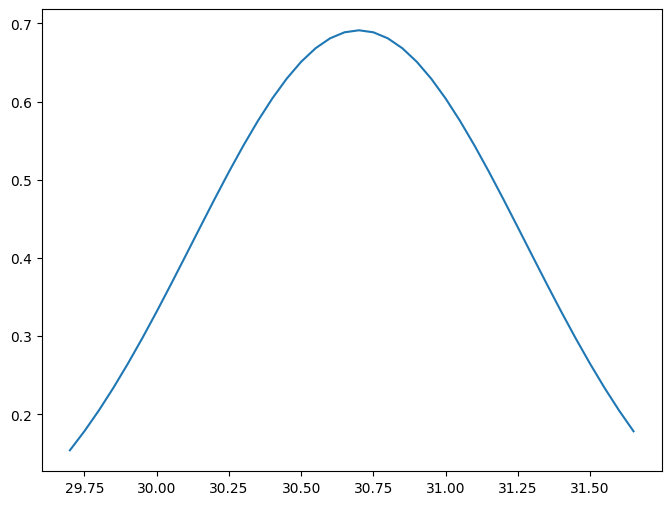

In [32]:
# Average: 30.7
# Fastest: 31.5
# "Slowest": 30.2

# Define our "tails" of a normal distribution
# Bounds:

# Code stolen from: https://www.statology.org/generate-normal-distribution-python/

# impute range of x-values
x = np.arange(29.7, 31.7, 0.05)

# create range of y-values for normal pdf with defined mean and standard dev.
y = norm.pdf(x, 30.7, np.std(x))

# plot 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,y)
plt.style.use('fivethirtyeight')
plt.show()



In [33]:
mean, std = 30.7, np.std(x) # mean and standard deviation
dist = np.random.normal(mean, std, carroll_hit_data.shape[0])

dist

array([31.36091438, 31.23584837, 30.63296568, 31.18999256, 30.11304272,
       29.68698603, 31.31446252, 29.99141865, 30.43709088, 31.10143809,
       30.66502174, 30.13512184, 30.31652017, 31.52495988, 30.07828733,
       31.4479399 , 31.15229333, 30.90661118, 29.26406677, 31.23909551,
       31.16216528, 30.45344164, 29.78545587, 30.54634707, 29.87531364,
       30.62458089])

In [34]:
carroll_hit_data['sprint_speed'] = dist
carroll_hit_data.head(10)

,game_date,player_id,events,des,bb_type,launch_speed_angle,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,delta_run_exp,angle,r,calc_distance,sprint_speed
0,26,682998,triple,Corbin Carroll triples (2) on a sharp line dri...,line_drive,5.0,107.5,13.0,0.806,0.841,0.912,1.447838,135.835532,315.0,31.360914
1,26,682998,single,Corbin Carroll singles on a ground ball to sho...,ground_ball,2.0,83.1,-33.0,0.063,0.063,0.637,1.925423,57.337780,133.0,31.235848
2,26,682998,double,Corbin Carroll doubles (9) on a fly ball to le...,fly_ball,3.0,77.1,49.0,0.069,0.062,0.633,2.282218,105.144434,244.0,30.632966
3,26,682998,double,Corbin Carroll doubles (8) on a line drive to ...,line_drive,4.0,99.7,16.0,0.571,0.590,0.261,0.944309,120.023372,279.0,31.189993
4,26,682998,double,Corbin Carroll doubles (7) on a ground ball to...,ground_ball,2.0,99.2,-6.0,0.260,0.234,0.750,1.487149,113.225883,263.0,30.113043
5,25,682998,single,Corbin Carroll singles on a soft ground ball t...,ground_ball,1.0,47.8,-67.0,0.214,0.193,0.102,2.051628,20.820867,48.0,29.686986
6,25,682998,single,Corbin Carroll singles on a sharp line drive t...,line_drive,4.0,103.5,12.0,0.889,0.893,0.270,2.015133,136.184042,316.0,31.314463
7,24,682998,double,Corbin Carroll doubles (6) on a sharp line dri...,line_drive,5.0,107.0,15.0,0.637,0.702,1.848,1.506870,155.597821,361.0,29.991419
8,24,682998,single,Corbin Carroll singles on a fly ball to right ...,fly_ball,4.0,69.2,27.0,0.951,0.917,0.404,1.133392,104.133765,242.0,30.437091
9,24,682998,triple,Corbin Carroll triples (1) on a line drive to ...,line_drive,4.0,91.8,16.0,0.837,0.844,1.216,0.876622,134.052074,311.0,31.101438


# Final Data Cleaning

After some analysis of variables, a dataset to instantiate models with can now be defined. To keep things simple, I will just reimport the dataset and apply much of the same code in a more concise and straightforward manner. 

In [141]:
# Statcast lookup
carroll_id = playerid_lookup('carroll','corbin')['key_mlbam'][0]

carroll = statcast_batter('2022-04-01', '2022-10-03', player_id = carroll_id)

Gathering Player Data


In [142]:
hit_vars = ['events','game_date','home_team','batter','bb_type', 'des', "launch_speed","launch_angle",'hc_x', 'hc_y','hit_distance_sc']

carroll = carroll[hit_vars]
hits = ['triple','single','double','home_run']

carroll_hits = carroll[carroll['events'].isin(hits)]
carroll_hits.head()

,events,game_date,home_team,batter,bb_type,des,launch_speed,launch_angle,hc_x,hc_y,hit_distance_sc
0,triple,2022-10-03,MIL,682998,line_drive,Corbin Carroll triples (2) on a sharp line dri...,107.5,13.0,146.66,75.19,311.0
36,single,2022-10-02,SF,682998,ground_ball,Corbin Carroll singles on a ground ball to sho...,83.1,-33.0,110.09,156.23,3.0
44,double,2022-10-01,SF,682998,fly_ball,Corbin Carroll doubles (9) on a fly ball to le...,77.1,49.0,61.35,130.36,233.0
45,double,2022-10-01,SF,682998,line_drive,Corbin Carroll doubles (8) on a line drive to ...,99.7,16.0,200.37,112.77,233.0
69,double,2022-09-30,SF,682998,ground_ball,Corbin Carroll doubles (7) on a ground ball to...,99.2,-6.0,139.46,97.17,20.0


In [143]:
season_start = datetime.strptime('2022-04-01', '%Y-%m-%d').date()
carroll_hits['game_date'] = carroll_hits['game_date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').date() - season_start).days // 7)
carroll_hits = carroll_hits.rename(columns = {'game_date':'game_week'})

<ipython-input-143-78a294a33a6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carroll_hits['game_date'] = carroll_hits['game_date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').date() - season_start).days // 7)


In [144]:
# Takes negative arctangent of translated x and y coordiantes (x/y), shifted by pi/2  to match appearance of spraychart
carroll_hits['angle'] = (-1*np.arctan((carroll_hits.hc_x - 130)/(210 - carroll_hits.hc_y))) + (np.pi / 2)

# Given x and y, we calculate r value for polar coordiantes by simply taking hypotenuse of x and y
carroll_hits['r'] = np.hypot((210 - carroll_hits.hc_y),(carroll_hits.hc_x - 130))

In [145]:
# taking all home runs, average over the proportion of projected distance to r value
r_value_multiplier = np.mean(carroll_hits[carroll_hits.events == 'home_run']['hit_distance_sc'] / carroll_hits[carroll_hits.events == 'home_run']['r'])

# Scale up all values by r-value scalar to get better measure of total distance traveled
carroll_hits['calc_distance'] = round(carroll_hits['r'] * r_value_multiplier,0)
carroll_hits = carroll_hits.drop(['hc_x','hc_y','hit_distance_sc'], axis = 1)
carroll_hits = carroll_hits[carroll_hits['events'] != 'home_run']
carroll_hits.head()

,events,game_week,home_team,batter,bb_type,des,launch_speed,launch_angle,angle,r,calc_distance
0,triple,26,MIL,682998,line_drive,Corbin Carroll triples (2) on a sharp line dri...,107.5,13.0,1.447838,135.835532,315.0
36,single,26,SF,682998,ground_ball,Corbin Carroll singles on a ground ball to sho...,83.1,-33.0,1.925423,57.337780,133.0
44,double,26,SF,682998,fly_ball,Corbin Carroll doubles (9) on a fly ball to le...,77.1,49.0,2.282218,105.144434,244.0
45,double,26,SF,682998,line_drive,Corbin Carroll doubles (8) on a line drive to ...,99.7,16.0,0.944309,120.023372,279.0
69,double,26,SF,682998,ground_ball,Corbin Carroll doubles (7) on a ground ball to...,99.2,-6.0,1.487149,113.225883,263.0


In [146]:
sprint_data22 = statcast_running_splits(2022, 1, raw_splits = True)
speed_data22 = statcast_sprint_speed(2022, 1)

carroll_hits = carroll_hits.rename(columns = {'batter':'player_id'})

carroll_hits = carroll_hits[~carroll_hits['des'].str.contains('fielding error')]

carroll_hits = carroll_hits.merge(speed_data22[['player_id', 'sprint_speed']], on = 'player_id', how = 'left')

mean_sprint_speed = speed_data22['sprint_speed'].loc[speed_data22['player_id'] == carroll_id].values[0]
x = np.arange(mean_sprint_speed - 1, mean_sprint_speed + 1, 0.05)

# create range of y-values for normal pdf with defined mean and standard dev.
y = norm.pdf(x, mean_sprint_speed, np.std(x))

mean, std = mean_sprint_speed, np.std(x) # mean and standard deviation
dist = np.random.normal(mean, std, carroll_hits.shape[0])
carroll_hits['sprint_speed'] = dist

In [147]:
carroll_hits = carroll_hits.drop(['des','player_id','r'], axis = 1)

In [148]:
carroll_hits = carroll_hits[['events','game_week','home_team','launch_speed','launch_angle','angle','calc_distance','sprint_speed']]
carroll_hits

,events,game_week,home_team,launch_speed,launch_angle,angle,calc_distance,sprint_speed
0,triple,26,MIL,107.5,13.0,1.447838,315.0,30.708024
1,single,26,SF,83.1,-33.0,1.925423,133.0,30.674635
2,double,26,SF,77.1,49.0,2.282218,244.0,31.488736
3,double,26,SF,99.7,16.0,0.944309,279.0,30.668742
4,double,26,SF,99.2,-6.0,1.487149,263.0,31.010201
5,single,25,HOU,47.8,-67.0,2.051628,48.0,30.010380
6,single,25,AZ,103.5,12.0,2.015133,316.0,31.171777
7,double,24,LAD,107.0,15.0,1.506870,361.0,31.115122
8,single,24,LAD,69.2,27.0,1.133392,242.0,29.809880
9,triple,24,LAD,91.8,16.0,0.876622,311.0,31.223592


## EDA

As a final step, I will look at each variable in the dataset to find out how to preprocess each variable before instantiating any models that require doing so. I have dealt with some of this previously when transforming game_date into game_week, but the continuous variables in the dataset have not been visualized. Using a simple pairplot, we can visualize all continuous variable's distributions for Corbin Carroll. Since he had a small sample of batted balls, I looked at other players to visualize their distributions. I conclude my column scaling to be the following scheme:

* MinMax: game_week, launch_speed, angle
* StandardScaler: launch_angle, calc_distance, sprint_speed
* One-Hot Encode: home_team


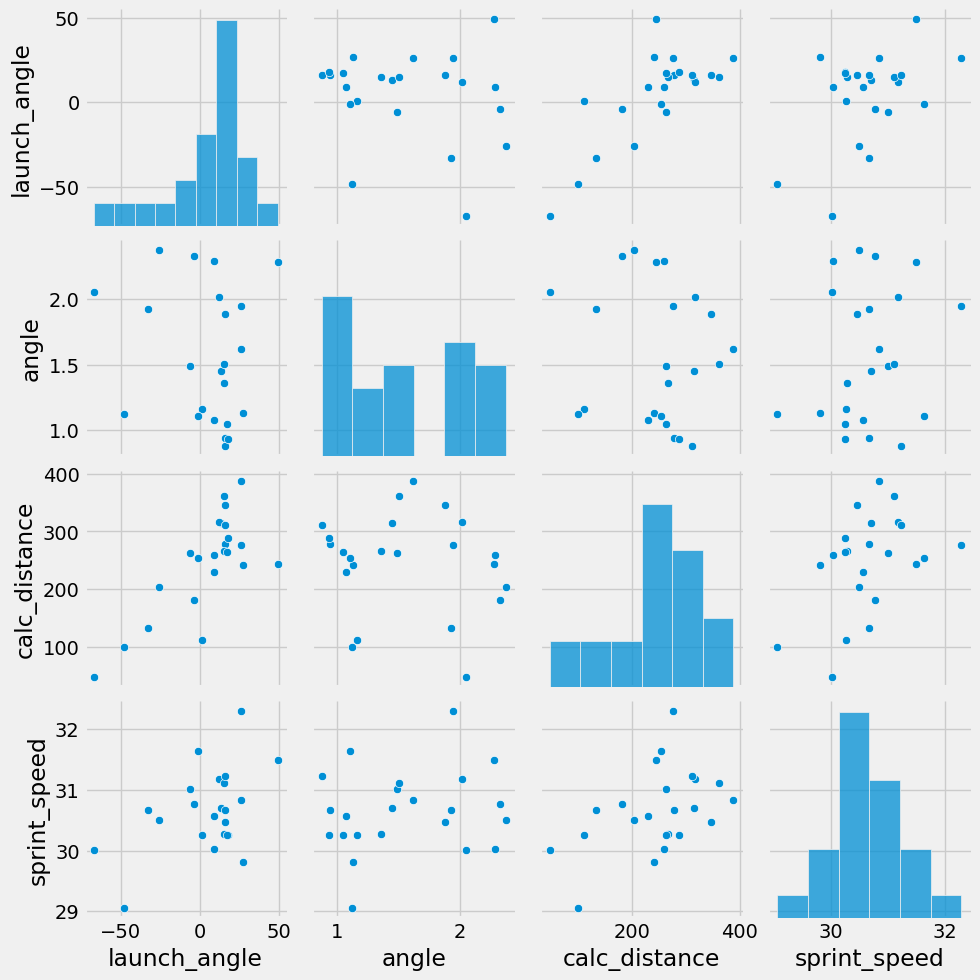

In [149]:
sns.pairplot(carroll_hits.iloc[:,4:])

# Final Application

To conclude, I want to have a dataset I can use to instantiate a model that applies to all players. Similar code will be used, with the exception of imputing sprint speed, which will have to be done for each data point according to the player_id value in the same row. 

In [197]:
start_date = '2022-04-01'
data = statcast(start_date, '2022-10-03')
#data = statcast(start_date, start_date)
sprint_data22 = statcast_running_splits(2022, 1, raw_splits = True)
speed_data22 = statcast_sprint_speed(2022, 1)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 186/186 [05:11<00:00,  1.67s/it]


In [198]:
hit_vars = ['events','game_date','home_team','batter','bb_type', 'des', "launch_speed", "launch_angle",'hc_x', 'hc_y','hit_distance_sc']

# Limit variables, and runners who do not have sprint speed data
data = data[hit_vars]
data = data[data['batter'].isin(speed_data22['player_id'].unique())]

# Handle the launch_speed, launch_angle, hc_x, hc_y, hit_distance_sc na values

hits = ['triple','single','double','home_run']

hits = data[data['events'].isin(hits)]

season_start = datetime.strptime(start_date, '%Y-%m-%d').date()
hits['game_date'] = hits.apply(lambda x: (x['game_date'].date() - season_start).days // 7, axis = 1)

hits = hits.rename(columns = {'game_date':'game_week'})

# Takes negative arctangent of translated x and y coordiantes (x/y), shifted by pi/2  to match appearance of spraychart
hits['angle'] = (-1*np.arctan((hits.hc_x - 130)/(210 - hits.hc_y))) + (np.pi / 2)

# Given x and y, we calculate r value for polar coordiantes by simply taking hypotenuse of x and y
hits['r'] = np.hypot((210 - hits.hc_y),(hits.hc_x - 130))

# taking all home runs, average over the proportion of projected distance to r value
r_value_multiplier = np.mean(hits[hits.events == 'home_run']['hit_distance_sc'] / hits[hits.events == 'home_run']['r'])

# Scale up all values by r-value scalar to get better measure of total distance traveled
hits['calc_distance'] = round(hits['r'] * r_value_multiplier,0)
hits = hits.drop(['hc_x','hc_y','hit_distance_sc'], axis = 1)
hits = hits[hits['events'] != 'home_run']


hits = hits.rename(columns = {'batter':'player_id'})
hits = hits[~hits['des'].str.contains('fielding error')]

hits['sprint_speed'] = hits.apply(lambda x: np.random.normal(speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0], np.std(np.arange(speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0] - 1, speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0] + 1, 0.05)), 1)[0], axis = 1)

hits = hits.drop(['des','player_id','r'], axis = 1)
hits = hits[['events','game_week','home_team','launch_speed','launch_angle','angle','calc_distance','sprint_speed']]

hits

<ipython-input-198-7919b937cbcd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['game_date'] = hits.apply(lambda x: (x['game_date'] .date() - season_start).days // 7, axis = 1)


,events,game_week,home_team,launch_speed,launch_angle,angle,calc_distance,sprint_speed
3130,triple,26,BOS,105.9,13,1.386628,322.0,27.908417
452,single,26,BOS,105.7,20,1.920752,301.0,26.835223
820,single,26,BOS,92.3,0,1.928362,227.0,27.233865
1166,double,26,BOS,78.5,25,0.83157,292.0,25.734528
2800,single,26,BOS,105.9,15,1.347517,319.0,27.783724
...,...,...,...,...,...,...,...,...
1280,single,0,TB,<NA>,<NA>,2.072915,258.0,28.076965
1532,double,0,TB,<NA>,<NA>,0.876957,272.0,28.435997
1590,single,0,TB,<NA>,<NA>,1.967748,249.0,28.188946
1620,single,0,TB,<NA>,<NA>,1.622986,284.0,27.190928
